# Analyze SoHappy output files - Significance and time distributions

In [1]:
import gammapy
gammapy.__version__

import sys
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import init as init

plt.style.use('seaborn-talk') # Make the labels readable
#plt.style.use('seaborn-poster') # Make the labels readable - bug with normal x marker !!!
codefolder = "../../" 
sys.path.append(codefolder) 
from utilities import MyLabel
from utilities import stamp

col_n = "tab:blue"
col_s = "tab:red"
col_b = "tab:purple"

## Read data
Change folder name here

In [2]:
outfolder= "../../../output/test-std-newvisimplemntation-24deg/"
outfolder="../../../output/new17-107-137-24deg-newirf-100iter-noacceleration-Full_N-MST_S/"
import os
os.listdir(outfolder)

['analysis.log',
 'config.py',
 'data.csv',
 'data.txt',
 'new17-107-137-24deg-newirf-100iter-noacceleration-Full_N-MST_S_20210324_134758.tar.gz']

In [3]:
file = init.create_csv(outfolder)
(grb, gn0, gs0, gn, gs, gb) = init.get_data(file, debug=True)

../../../output/new17-107-137-24deg-newirf-100iter-noacceleration-Full_N-MST_S/data.csv  exists
 DATA READING from  ../../../output/new17-107-137-24deg-newirf-100iter-noacceleration-Full_N-MST_S/data.csv
Supplementary information is present
 grb.N==1 seen North only
 gbr.S==1 seen South only
 grb.B==1 seen on both

+-------------------------- Flags ---------------------------+
 Flags:
   No visible flag, unvis           =  -999
   Iteration # from error code, 3s and 5s counts :  100 100 100
+----------------------- Statistics -------------------------+
   Not visible   Fully analyzed      Aborted    
      1374            1626              0       

 Raw statistics - max per site = 2000
  - total      :  3000
  - analyzable :  1626
  - North      :  599
  - South      :  613
  - Both sites :  414 -> total =  1626
  - North only :  187
  - South only :  201
+------------------------------------------------------------+


## Coherence check
The significance is returned by the WStatCountsStatistic function in gammapy, and has a sign which corresponds to the sign of the excess. As a consequence it can be negative.
In case the simulation is done without fluctuation and one trial, the excess can not be negative, and all significance are zero (no excess count) or more.

<font size=30 color="#FF0000">TO BE INVESTIGATED</FONT>

In [4]:
for g,txt in zip([gn, gs, gn0, gs0, gb],["North", "South", "North only","South only","Both"]):
    n_pos = len(g[g.sigmx>0])
    n0    = len(g[g.sigmx==0])
    n_neg = len(g[g.sigmx<0])
    if n_neg == 0: fluctuate = False
    print(" {:10s} <0: {:<5d} ==0: {:<5d} >0: {:<5d}"
          .format(txt,n_neg,n0,n_pos))

 North      <0: 6     ==0: 4     >0: 589  
 South      <0: 11    ==0: 11    >0: 591  
 North only <0: 0     ==0: 0     >0: 187  
 South only <0: 6     ==0: 5     >0: 190  
 Both       <0: 0     ==0: 1     >0: 413  


## Max. Significance distribution
Check anomalies

In [5]:
def plot_sigmax(g,color="tab:blue",ax=None,xscale="log",bins=25,tag="",xmax=None):
    
    if (ax==None): fig,ax = plt.subplots()
        
    if (xmax != None): mask = g.sigmx < xmax
    else:              mask=np.ones(len(g),dtype=bool)
        
    if xscale=="log":
        mask = g.sigmx>0 & mask 
        x = np.log10(g[mask].sigmx)
        ax.set_title("Positive values only")
        ax.set_xlabel("$log_{10}(\sigma_{max})$")   
        ax.axvline(x=np.log10(3),color="tab:orange",ls=":",label="$3\sigma$")
        ax.axvline(x=np.log10(5),color="tab:green",ls=":",label="$5\sigma$") 
    else:
        x = g[mask].sigmx
        ax.set_xlabel("$\sigma_{max}$")
        ax.axvline(x=3.,color="tab:orange",ls=":",label="$3\sigma$")
        ax.axvline(x=5,color="tab:green",ls=":"  ,label="$5\sigma$")   
        
    n, bins,_ = ax.hist(x, bins=bins, alpha=0.5,facecolor=color, label=MyLabel(x,tag,stat="med")) 
    
    import collections
    handles, labels = ax.get_legend_handles_labels()
    by_label = collections.OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    return (ax, bins)

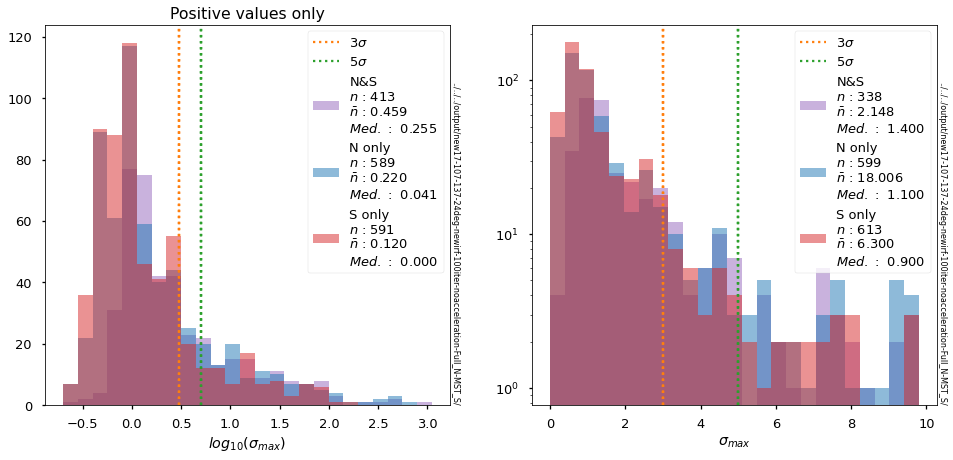

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(16,7))

xscale = "log"
(ax, bins) = plot_sigmax(gb, ax=ax1, color=col_b, xscale=xscale,tag="N&S")
plot_sigmax(gn, ax=ax, bins=bins, color = col_n, xscale=xscale,tag="N only")
plot_sigmax(gs, ax=ax, bins=bins, color = col_s, xscale=xscale,tag="S only")
stamp(ax, outfolder)

xscale = "linear"
(ax, bins) = plot_sigmax(gb, ax=ax2, color=col_b, xscale=xscale,tag="N&S",xmax=10)
plot_sigmax(gn, ax=ax, bins=bins, color = col_n, xscale=xscale,tag="N only")
plot_sigmax(gs, ax=ax, bins=bins, color = col_s, xscale=xscale,tag="S only")
stamp(ax, outfolder)
ax.set_yscale("log")

### Check highest $\sigma_{max}$ values

In [7]:
def high_sigma(gpop,ax=None,color="grey",inset=True, maxsigmx= 100, nbin=100,tag=""):

    n,bins,_ = ax.hist(gpop.sigmx,bins=nbin,label=MyLabel(gpop.sigmx,tag,stat="med"),facecolor=color)
    ax.set_yscale("log")
    ax.set_xlabel("$\sigma_{max}$")
    ax.set_ylabel("Event counts")
    ax.legend(loc="upper left")
    #ax.set_title("Negative significances excluded")   
    # Inset in log
    if (inset):
        axx = inset_axes(ax, width="75%", height=1.2,loc="upper right")
        n,bins,_ = axx.hist(np.log10(gpop[gpop.sigmx>0].sigmx),
                           bins=25,edgecolor="black",facecolor=color,
                            alpha=0.5)
        axx.axvline(np.log10(3),ls=":",color="red",lw="2",label="$3\sigma$")
        axx.axvline(np.log10(5),color="red",lw="2",label="$5\sigma$")
        axx.set_xlabel("Log $\sigma_{max}$")
        axx.legend()

    # Outliers
    outlier=zip(gpop[gpop.sigmx>maxsigmx].name,gpop[gpop.sigmx>maxsigmx].sigmx)
    i=1
    for g in outlier:
        y = 1+(i%3)
        ax.text(x=g[1],y=y,s=g[0][5:],rotation=45)
        i+=1
    return

C:\Users\stolar\AppData\Local\Continuum\anaconda3\gpy0.17\lib\site-packages\ipykernel_launcher.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """


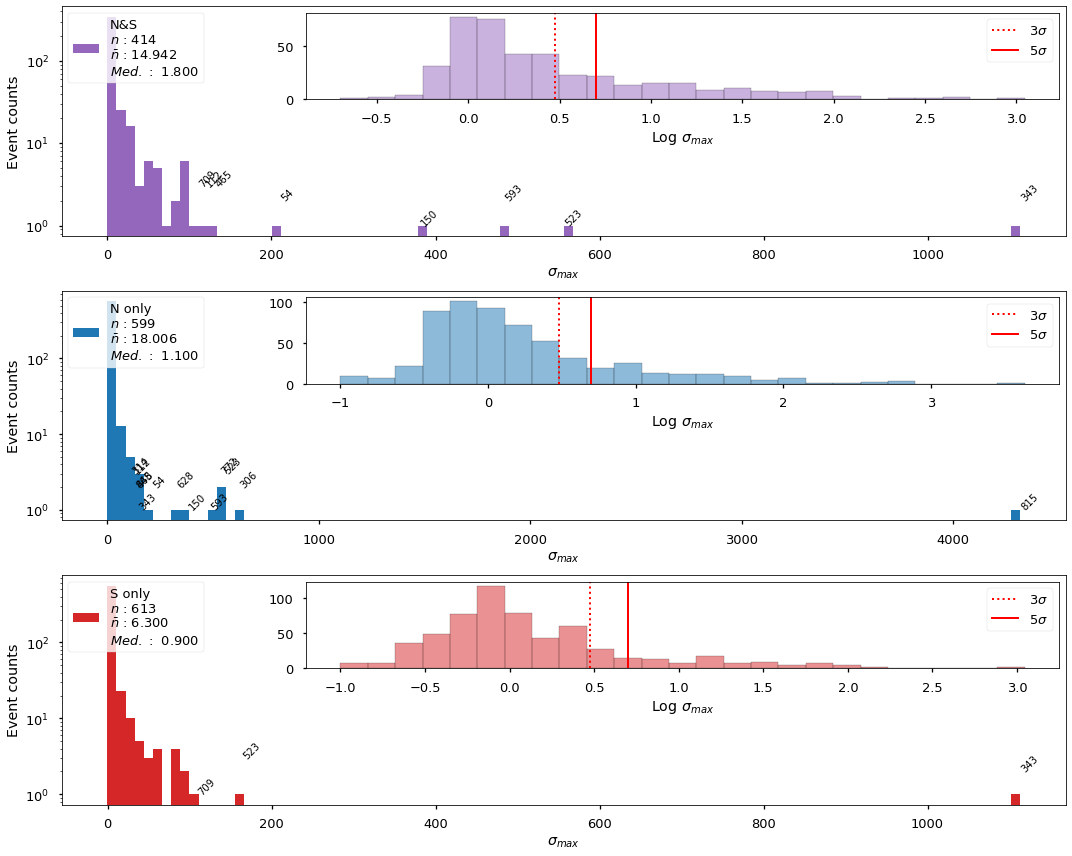

In [8]:
fig,ax = plt.subplots(nrows=3, ncols=1,figsize=(15,12))
high_sigma(gb,color=col_b,ax=ax[0],tag="N&S")
high_sigma(gn,color=col_n,ax=ax[1],tag="N only")
high_sigma(gs,color=col_s,ax=ax[2],tag="S only")
plt.tight_layout()

### Check lowest values
Not exciting

C:\Users\stolar\AppData\Local\Continuum\anaconda3\gpy0.17\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


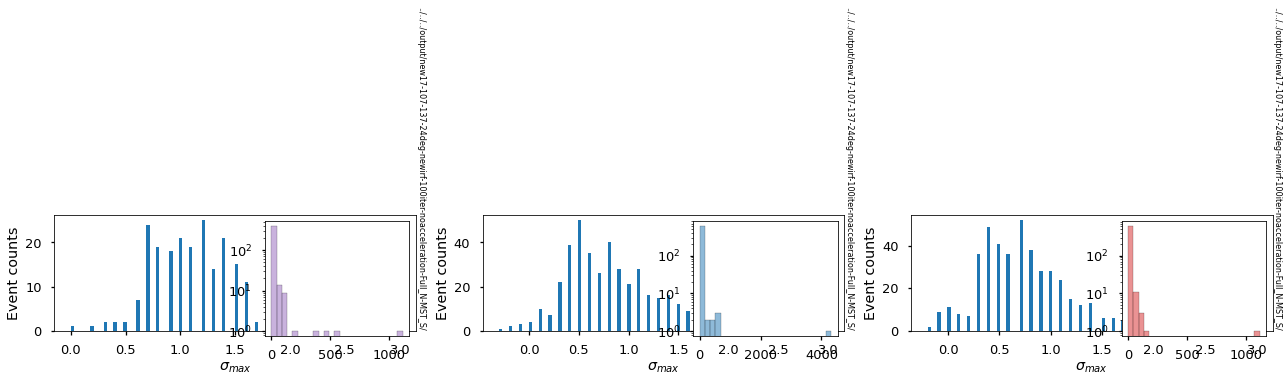

In [9]:
def low_sigma(gpop,ax=None,color="grey",inset=True,maxsigmx=3,nbin=100,tag=""):
    n,bins,_ = ax.hist(gpop.sigmx[gpop.sigmx <= maxsigmx],
                       bins=nbin,label=MyLabel(gpop.sigmx[gpop.sigmx <= maxsigmx],tag,stat="med"))
    ax.set_xlabel("$\sigma_{max}$")
    ax.set_ylabel("Event counts")
    ax.legend(loc="lower right")
    stamp(ax,outfolder)
    #ax.set_title("Negative significances included")
    
    if (inset):
        axx = inset_axes(ax, width="40%", height=1.6, loc="upper right")
        n,bins,_ = axx.hist(gpop.sigmx,bins=25,edgecolor="black",facecolor=color,
                            alpha=0.5,label=MyLabel(gpop.sigmx,tag))
        axx.set_yscale("log")
    return
fig,ax = plt.subplots(nrows=1, ncols=3,figsize=(18,4))
low_sigma(gb,color=col_b,ax=ax[0],tag="N&S")
low_sigma(gn,color=col_n,ax=ax[1],tag="N only")
low_sigma(gs,color=col_s,ax=ax[2],tag="S only")
plt.tight_layout()

## Time distributions

In [11]:
def time_plot(var,ax=None, bins=25,xlabel="",tag="",color="tab:blue"):
    
    if (ax==None): ax = plt.subplots()
    n, bins,_ = ax.hist(var, bins=nbin, alpha=0.5,facecolor=color,
                        label=MyLabel(var,"N&S",stat="med"))  
    ax.axvline(x=np.log10(3600),ls=":",color="green",label="1h hour")
    ax.axvline(x=np.log10(12*3600),ls=":",color="blue",label="12h hour")
    ax.axvline(x=np.log10(24*3600),ls=":",color="red",label="One day")

    ax.set_xlabel("$log_{10}(\Delta t_{max})$")    
    
    import collections
    handles, labels = ax.get_legend_handles_labels()
    by_label = collections.OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    return (ax, bins)

### Max significance

NameError: name 'nbin' is not defined

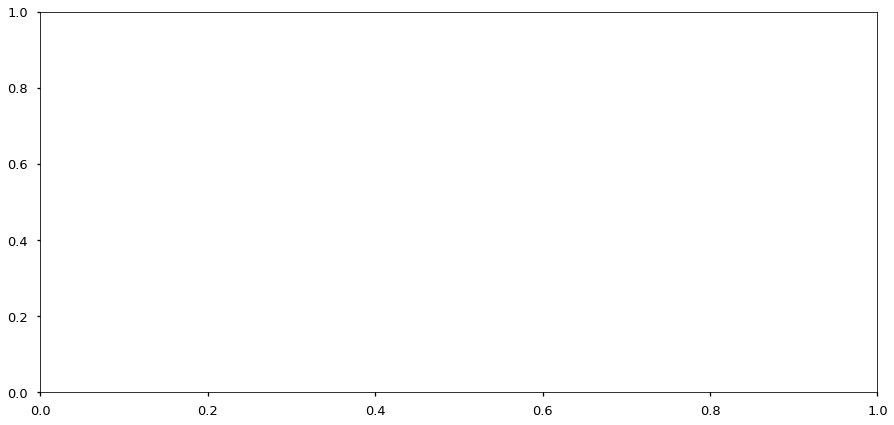

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,7))

xlabel = "$log_{10}(\Delta t_{max})$"
mask = gb.sigmx>0
(ax, bins) = time_plot( np.log10(gb[mask].tmx), ax=ax, xlabel=xlabel, tag="N&S",color=col_b)
mask = gn.sigmx>0
time_plot( np.log10(gn[mask].tmx), bins=bins, ax=ax, xlabel=xlabel, tag="N only",color=col_n)
mask = gs.sigmx>0
time_plot( np.log10(gs[mask].tmx), ax=ax, xlabel=xlabel, tag="S only",color=col_s)

### Correlation $\Delta t_{max} - \sigma_{max}$ 

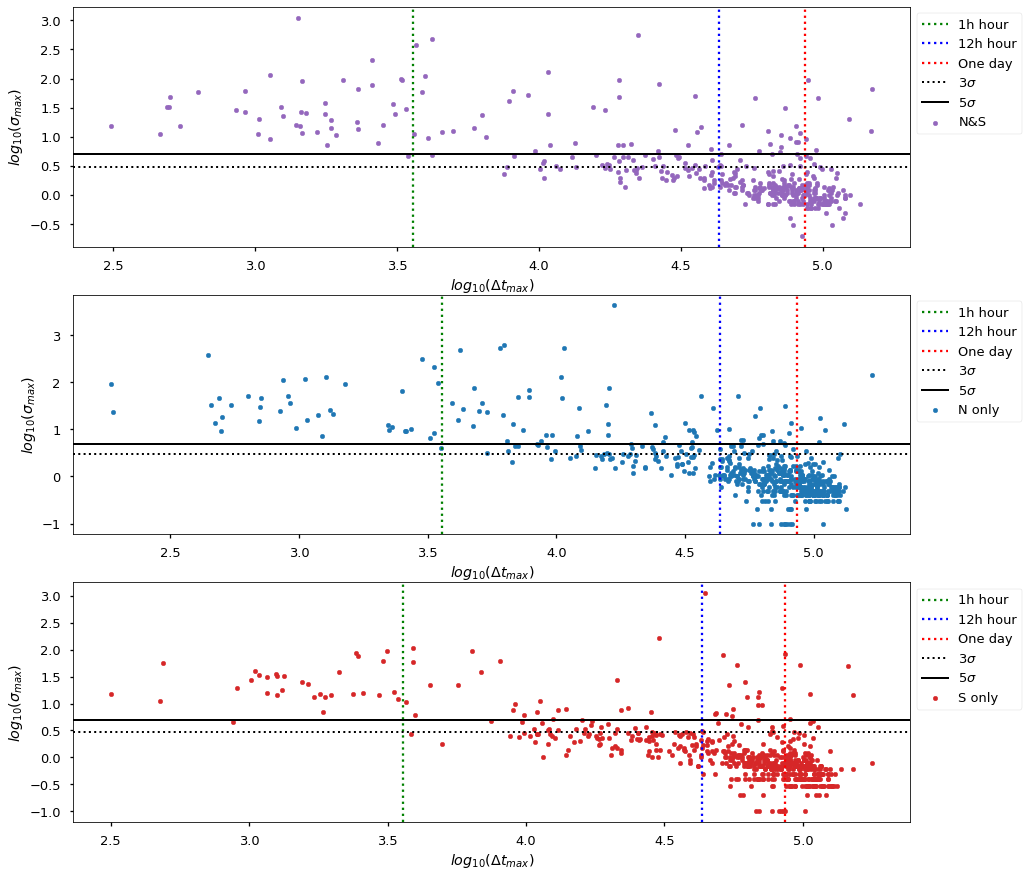

In [13]:
def plot_t_sigma(g,ax=None,tag="",color="tab:blue"):
    if (ax==None): ax = plt.subplots()
    mask = g.sigmx>0
    ax.scatter(np.log10(g[mask].tmx),np.log10(g[mask].sigmx),marker=".",color=color,label=tag)
    ax.set_xlabel("$log_{10}(\Delta t_{max})$")
    ax.set_ylabel("$log_{10}(\sigma_{max})$")
    ax.axvline(x=np.log10(3600),ls=":",color="green",label="1h hour")
    ax.axvline(x=np.log10(12*3600),ls=":",color="blue",label="12h hour")
    ax.axvline(x=np.log10(24*3600),ls=":",color="red",label="One day")
    
    ax.axhline(np.log10(3),ls=":",color="black",lw="2",label="$3\sigma$")
    ax.axhline(np.log10(5),color="black",lw="2",label="$5\sigma$")
    
    ax.legend(bbox_to_anchor=(1,1), loc="upper left")

    return
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(15,15))
plot_t_sigma(gb, ax=ax[0],tag="N&S",color=col_b)
plot_t_sigma(gn, ax=ax[1],tag="N only",color=col_n)
plot_t_sigma(gs, ax=ax[2],tag="S only",color=col_s)

### GRB with max siginificance obtained after one day

In [14]:
for g,txt in zip([gn, gs, gb],["North","South","Both"]):
    mask = g.sigmx>0
#     late_list = g[mask & g.tmx>24*3600]
    late_list = g[mask][g[mask].tmx>24*3600]
    print(" {:5s} {:4d}"":".format(txt,len(late_list)))
    for s, sigma in zip(late_list.name,late_list.sigmx):
        print("    Evt: ",s," sig=",sigma,end="")
        if (sigma >= 3): print(" *")
        else: print()

 North  188:
    Evt:  Event5  sig= 0.4
    Evt:  Event9  sig= 0.3
    Evt:  Event14  sig= 0.4
    Evt:  Event15  sig= 0.3
    Evt:  Event16  sig= 0.9
    Evt:  Event20  sig= 1.4
    Evt:  Event22  sig= 1.3
    Evt:  Event23  sig= 0.4
    Evt:  Event33  sig= 0.5
    Evt:  Event52  sig= 1.8
    Evt:  Event57  sig= 2.5
    Evt:  Event65  sig= 0.8
    Evt:  Event67  sig= 0.5
    Evt:  Event69  sig= 9.6 *
    Evt:  Event70  sig= 0.5
    Evt:  Event78  sig= 0.6
    Evt:  Event98  sig= 0.6
    Evt:  Event101  sig= 0.5
    Evt:  Event102  sig= 0.3
    Evt:  Event109  sig= 0.5
    Evt:  Event117  sig= 1.0
    Evt:  Event122  sig= 0.5
    Evt:  Event125  sig= 0.3
    Evt:  Event134  sig= 0.5
    Evt:  Event139  sig= 0.4
    Evt:  Event140  sig= 0.5
    Evt:  Event141  sig= 0.4
    Evt:  Event147  sig= 0.6
    Evt:  Event148  sig= 0.5
    Evt:  Event157  sig= 0.5
    Evt:  Event159  sig= 1.1
    Evt:  Event170  sig= 0.4
    Evt:  Event172  sig= 0.5
    Evt:  Event190  sig= 0.6
    Evt:  Event201

    Evt:  Event950  sig= 0.8
    Evt:  Event987  sig= 0.7
    Evt:  Event998  sig= 0.9


In [15]:
late_list.name

8         Event3
20        Event7
98       Event33
131      Event44
155      Event52
          ...   
2714    Event905
2789    Event930
2849    Event950
2960    Event987
2993    Event998
Name: name, Length: 98, dtype: object

### 3 and 5 $\sigma$

C:\Users\stolar\AppData\Local\Continuum\anaconda3\gpy0.17\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


NameError: name 'nbin' is not defined

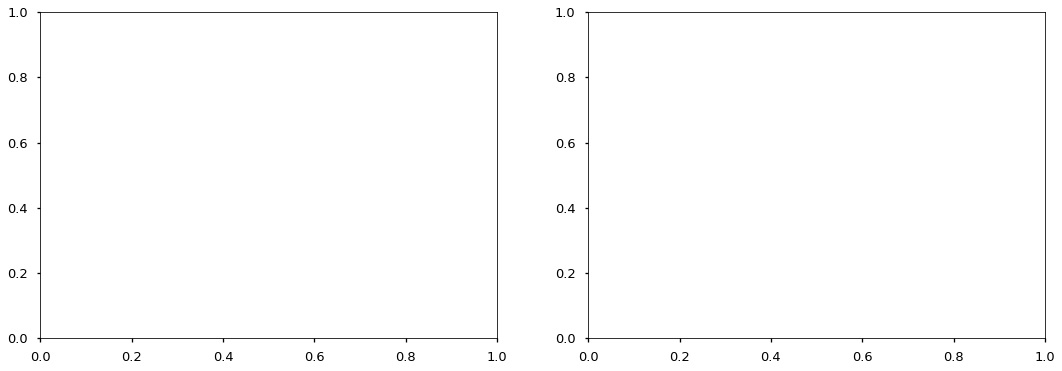

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(18,6))

xlabel = "$log_{10}(\Delta t_{3\sigma})$"
mask = gb.sigmx>0
(ax, bins) = time_plot( np.log10(gb[mask].t3s), ax=ax1, xlabel=xlabel, tag="N&S",color=col_b)
mask = gn.sigmx>0
time_plot( np.log10(gn[mask].t3s), bins=bins, ax=ax, xlabel=xlabel, tag="N only",color=col_n)
mask = gs.sigmx>0
time_plot( np.log10(gs[mask].t3s), ax=ax, xlabel=xlabel, tag="S only",color=col_s)

xlabel = "$log_{10}(\Delta t_{5\sigma})$"
mask = gb.sigmx>0
(ax, bins) = time_plot( np.log10(gb[mask].t5s), ax=ax2, xlabel=xlabel, tag="N&S",color=col_b)
mask = gn.sigmx>0
time_plot( np.log10(gn[mask].t5s), bins=bins, ax=ax, xlabel=xlabel, tag="N only",color=col_n)
mask = gs.sigmx>0
time_plot( np.log10(gs[mask].t5s), ax=ax, xlabel=xlabel, tag="S only",color=col_s)

### GRB with 3 and 5 $\sigma$ siginificance obtained after one day

In [17]:
###-----------------------------------------------------------------------------
def plot_historical(ax = None, site ="nowhere"):
    """
    Display some well nknow GRB friends
    GRB 190114C	MAGIC	0.4245	3.00E+53
    GRB 180720B	HESS	0.654	6.00E+53abs
    GRB 190829A HESS    0.078   2.00E50   
    GRB 080916C		4.3	8.80E+54
    GRB 090902B		1.822	2.20E+52
    GRB 130427A		0.34	9.60E+63
    """
    if (site == "North"):
        ax.plot(0.4245,np.log10(3e53),marker="*",ms=15,lw=0,color="red",label="190114C")
    elif (site =="South"):
        ax.plot(0.654,np.log10(6e53),marker="*",ms=15,lw=0,color="red",label="180720B")
        ax.plot(0.0785,np.log10(2e50),marker="*",ms=15,lw=0,color="red",label="190829A")
    else:
        ax.plot(4.3  ,np.log10(8.8e54),marker="s",ms=10,lw=0,color="blue",alpha=0.8,label="080916C")
        ax.plot(1.822,np.log10(2.2e52),marker="X",ms=10,lw=0,color="blue",alpha=0.8,label="090902B")
        ax.plot(0.34 ,np.log10(9.6e53),marker="D",ms=10,lw=0,color="blue",alpha=0.8,label="130427A")
    ax.legend(loc="lower right")
    return
###-----------------------------------------------------------------------------
def eiso_z(ginit, gpop, var,
           ax = None,
           color = "blue",
           size  = 20,
           title = "No title",
           label ="No label",
           xmin  = 0,xmax = 0,
           ymin  = 0,ymax = 0,
           archive=False,
           zlimit = 25,
           decoration=True):
    """
    Create a scatter plot of a (typically) detected population over an initial one
    """
    # Reference population
    ax.scatter(ginit.z, np.log10(ginit.Eiso), facecolor = "black", edgecolor = "black",
                marker = '.', alpha = 0.8, s = 10, label     = 'All')
    
    # Detected population
    sc = ax.scatter(gpop.z, np.log10(gpop.Eiso), 
               alpha = 0.5, c= color, s = size, label = label)
    #plt.colorbar(sc,ax = ax)
    # Decorate 
    ax.set_xlim(xmin=xmin,xmax=zlimit)
    if (ymin != ymax): ax.set_ylim(ymin=ymin,ymax=ymax)
    if (decoration):
        ax.set_xlabel("Redshift ($z$)")
        ax.set_ylabel("log10($E_{iso}$)")
        ax.set_title(title)
        ax.legend(loc="lower right")
        stamp(ax,outfolder)
    return

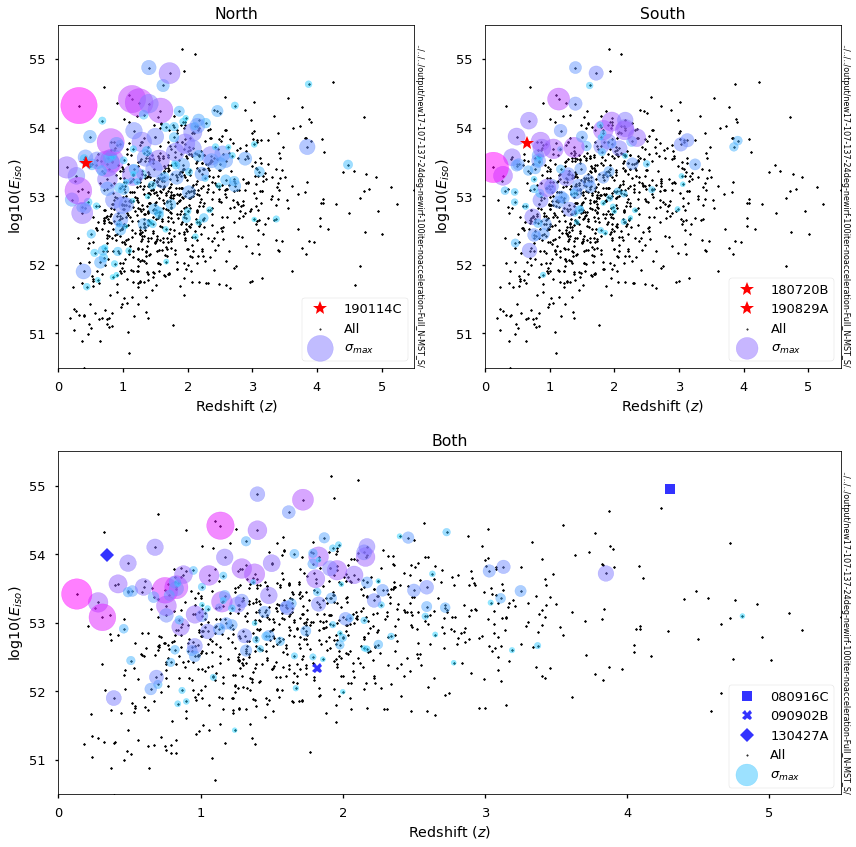

In [18]:
###-----------------------------------------------------------------------------
import matplotlib.cm as cm

plt.figure(figsize=(12,12))
ax3 = plt.subplot(212)
# ax1.margins(0.05)           # Default margin is 0.05, value 0 means fit
ax1 = plt.subplot(221)
#ax2.margins(2, 2)           # Values >0.0 zoom out
ax2 = plt.subplot(222)
# ax3.margins(x=0, y=-0.25)   # Values in (-0.5, 0.0) zooms in to center

zlimit = 7
for gpop, site, axis in zip([gn[gn.sigmx>3],gs[gs.sigmx>3],gb[gb.sigmx>3]],["North","South","Both"],[ax1,ax2,ax3]):
    var = gpop.sigmx
    #color  = -np.log10(var)
    #color = cm.rainbow(np.linspace(0, 1, n))
    #color = cm.viridis(np.linspace(0, 1, n))
    color = cm.cool(np.log10(var)/np.max(np.log10(var)))
    size   = 100*np.log10(var)**2
    eiso_z(grb,gpop,var,color=color,size=size,ax=axis, 
           label="$\sigma_{max}$",
           title=site,
           ymin=50.5,ymax=55.5,zlimit = 5.5)
    plot_historical(ax=axis,site=site)
    
    # Inset
#     if (site=="Both"):
#         axx = inset_axes(axis, width="30%", height=1.5,loc="upper right")
#         eiso_z(grb,gpop,var,color=color,size=size,ax=axx, 
#                label="$\sigma_{max}$",
#                title=site,
#                ymin=50.5,ymax=55.5,xmin=7,decoration=False)
plt.tight_layout()

# Have a look to North and South separately

Seen in North :  1000
        South :  1000
283


C:\Users\stolar\AppData\Local\Continuum\anaconda3\gpy0.17\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


NameError: name 'cm' is not defined

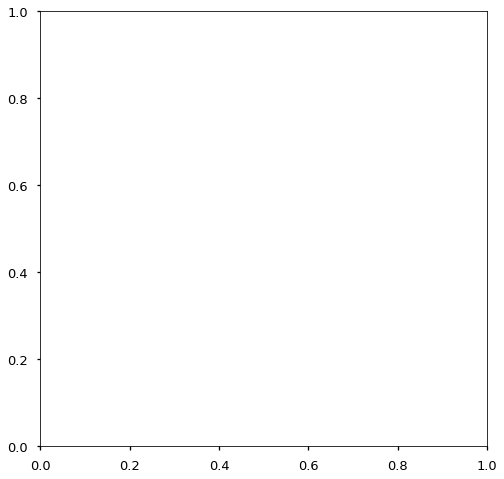

In [12]:
g_ana = grb
print("Seen in North : ",len(g_ana[g_ana.site=="North"]))
print("        South : ",len(g_ana[g_ana.site=="South"]))
plt.figure(figsize=(8,8))
ax = plt.subplot(111)

gpop = g_ana[g_ana.d3s>0][g_ana.site=="South"]
print(len(gpop))
var    = gpop.d3s
color = cm.rainbow(var/max(var))
size   = var
eiso_z(grb,gpop,var,color=color,size=size,ax=ax, 
           label="Detection fraction (100 trials)",
           title="South",
           ymin=50,ymax=55.5,zlimit = 7)


In [ ]:
plt.figure(figsize=(12,18))
ax3 = plt.subplot(212)
# ax1.margins(0.05)           # Default margin is 0.05, value 0 means fit
ax1 = plt.subplot(221)
#ax2.margins(2, 2)           # Values >0.0 zoom out
ax2 = plt.subplot(222)
# ax3.margins(x=0, y=-0.25)   # Values in (-0.5, 0.0) zooms in to center

zlimit = 7
for gpop, site, axis in zip([gn[gn.sigmx>3],gs[gs.sigmx>3],gb[gb.sigmx>3]],["North","South","Both"],[ax1,ax2,ax3]):
    var = gpop.sigmx
    #color  = -np.log10(var)
    #color = cm.rainbow(np.linspace(0, 1, n))
    #color = cm.viridis(np.linspace(0, 1, n))
    color = cm.cool(np.log10(var)/np.max(np.log10(var)))
    size   = 100*np.log10(var)**2
    eiso_z(grb,gpop,var,color=color,size=size,ax=axis, 
           label="$\sigma_{max}$",
           title=site,
           ymin=50,ymax=55.5,zlimit = 5.5)
    plot_historical(ax=axis,site=site)
    
    # Inset
#     if (site=="Both"):
#         axx = inset_axes(axis, width="30%", height=1.5,loc="upper right")
#         eiso_z(grb,gpop,var,color=color,size=size,ax=axx, 
#                label="$\sigma_{max}$",
#                title=site,
#                ymin=50.5,ymax=55.5,xmin=7,decoration=False)
plt.tight_layout()

In [ ]:
print("N : ",len(gn[gn.sigmx>500]))
print("S : ",len(gs[gs.sigmx>500]))
print("B : ",len(gb[gb.sigmx>500]))


In [ ]:
plt.hist(gb.tmx)

In [ ]:
plt.hist((gb.t5s[gb.t5s<100]),bins=100)
plt.semilogy()


In [ ]:
mask = gn.err==niter
plt.hist(gn[mask].err)
plt.show()

In [ ]:
gpops = grb[grb.site=="South"]
gpopn = grb[grb.site=="North"]
print(len(gpopn),len(gpops))
fig, ax = plt.subplots(nrows=1,ncols=1,)
ax.plot(gpops.nt,gpopn.nt,marker=".",ls="")
nmin=6
nmax = 15
ax.set_xlim(nmin,nmax)
ax.set_ylim(nmin,nmax)
for (x,y,name) in zip(gpops.nt,gpopn.nt,gpops.name):
    if (x>nmin and y>nmin and x<nmax and y<nmax): 
        ax.text(x,y,s=name[5:])
        print(name[5:],", ",end="")
print()

In [ ]:
n, bins, _ = plt.hist(gpops.nt,bins=25,alpha=0.5)
plt.hist(gpopn.nt,bins=bins,alpha=0.5)

In [ ]:
print(gpopn.name

In [ ]:
gpops.nt

In [ ]:
plt.hist(grb.altmx,bins=100)